In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ampel.ztf.util.ZTFIdMapper import to_ztf_id
from astropy.time import Time
from sklearn import metrics

In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=None, dpi=150, figsize=(4,4)):
    """
    Custom function to display a confusion matrix.
    """
    
    cm = metrics.confusion_matrix(
        y_true,
        y_pred,
        normalize=normalize
    )
    cmd = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    
    return cmd.plot(
        cmap=plt.cm.Greens,
        ax=ax,
    )

# Testing SNGuess as a Selection Tool

First we load a set of ZTF alerts over which SNGuess' unit was executed.

In [3]:
snguess = pd.read_csv('snguess_hu_tns_msip.csv')
snguess

,stockid,cut_pp,jd_det,jd_last,ndet,mag_det,mag_last,t_lc,rb_med,drb_med,...,slope_rise_g,slope_rise_r,col_det,col_last,col_peak,success,SNGuess,SNGuessBool,slope_fall_g,slope_fall_r
0,870833,0,2.459308e+06,2.459308e+06,1,19.805759,19.805759,0.000000,0.925714,1.000000,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
1,870833,0,2.459308e+06,2.459308e+06,1,20.053623,20.053623,0.000000,0.888571,1.000000,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
2,870833,0,2.459308e+06,2.459308e+06,2,19.805759,20.053623,0.046343,0.907143,1.000000,...,NaN,NaN,0.247864,0.247864,NaN,False,0.500000,NaN,NaN,NaN
3,870833,0,2.459308e+06,2.459308e+06,2,19.805759,20.053623,0.046343,0.907143,1.000000,...,NaN,NaN,0.247864,0.247864,NaN,True,-3.241392,0.0,NaN,NaN
4,877905,0,2.459320e+06,2.459320e+06,2,18.895201,19.179316,0.039549,0.856429,0.996535,...,NaN,NaN,0.284115,0.284115,NaN,False,0.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173397,628849937,0,2.459326e+06,2.459326e+06,1,16.497551,16.497551,0.000000,0.861429,0.999992,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
173398,628849937,0,2.459324e+06,2.459326e+06,2,16.225618,16.497551,1.970058,0.872857,0.999989,...,NaN,NaN,NaN,NaN,NaN,False,0.500000,NaN,NaN,NaN
173399,628849937,0,2.459324e+06,2.459326e+06,3,16.225618,16.545849,2.010463,0.884286,0.999992,...,NaN,NaN,NaN,-0.048298,NaN,False,0.500000,NaN,NaN,NaN
173400,628849937,0,2.459326e+06,2.459332e+06,3,16.497551,18.155434,6.040359,0.861429,0.999992,...,NaN,NaN,-0.048298,NaN,-0.048298,False,0.500000,NaN,0.274468,NaN


We calculate the ZTF names from the stock IDs and we add them to the table as a new column.

In [4]:
snguess['ztfname'] = to_ztf_id(snguess['stockid'])

In [5]:
print("%d alerts." % len(snguess))
print("%d candidates." % len(snguess.ztfname.unique()))
print("From %s..." % Time(snguess.jd_det.min(), format='jd').iso)
print("... to %s." % Time(snguess.jd_last.max(), format='jd').iso)

173402 alerts.
8969 candidates.
From 2020-10-08 05:03:39.997...
... to 2021-08-15 06:57:59.000.


Then, we load the transients picked up and classified by BTS. We obtain these by querying the BTS API @ CalTech (see `bts_transient_query.ipynb`).

In [6]:
bts_transients = pd.read_csv('bts_transients.csv', index_col='ZTFID')
bts_transients

,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
ZTFID,,,,,,,,,,,,,,
ZTF17aaahrni,AT2016dxt,05:21:41.58,-04:11:10.4,1155.90,g,17.1049,-,7.667,0.86,6.807,CV,-,-21.841960,0.827
ZTF17aaaikab,AT2019bgj,07:44:31.43,+48:26:30.4,1122.01,g,15.7679,-,>299.783,>294.2,5.583,CV,-,28.472792,0.155
ZTF17aaajnki,-,12:25:48.85,+33:32:48.7,462.05,r,17.8040,-,177.744,161.426,16.318,AGN,-,81.532942,0.047
ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
ZTF17aaanztg,AT2021abaw,10:04:06.59,-01:12:18.6,1501.02,r,18.3035,-,>14.737,>3,11.737,-,-,40.798111,0.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acqzsml,-,11:01:22.49,+29:47:22.7,1550.97,g,17.4320,-,>4.591,4.541,>0.05,-,-,65.720834,0.056
ZTF21acrarbx,SN2021afuu,13:55:15.77,+65:56:07.3,1551.04,r,18.8692,-16.80,>0.04,>0.04,>0,SN II,0.031,49.931886,0.045
ZTF21acrarrs,AT2021afuv,12:49:29.13,+18:43:37.0,1551.00,g,18.9032,-,>15.399,15.369,>0.03,-,-,81.586609,0.047


We add a boolean field to the table of SNGuess detections that indicates whether its object was picked up by BTS

In [7]:
targeted_by_bts = pd.Series(True, index=bts_transients.index, name='targeted_by_bts')
snguess = snguess.merge(targeted_by_bts, how='left', left_on='ztfname', right_index=True).fillna(value={'targeted_by_bts':False})

In [8]:
print("%d alerts of candidates in ZTF list targeted by BTS" % len(snguess[snguess.targeted_by_bts]))
print("%d candidates in ZTF alert list targeted by BTS" % len(snguess[snguess.targeted_by_bts].ztfname.unique()))

41175 alerts of candidates in ZTF list targeted by BTS
904 candidates in ZTF alert list targeted by BTS


We add a column to the SNGuess table with the type that BTS assigned to the detection's source object, when appropriate.

In [9]:
snguess = pd.merge(snguess, bts_transients['type'], left_on=['ztfname'], how='left', right_index=True)

In [10]:
idx_typed = snguess.type.notna() & (snguess.type != '-')
print("%d of the alerts are labeled." % len(snguess[idx_typed]))
print("%d of the candidates are typed." % len(snguess[idx_typed].ztfname.unique()))

31434 of the alerts are labeled.
620 of the candidates are typed.


Next, we fix the default marginal score of SNGuess (replacing 0.5 with 0.0).

In [11]:
snguess.loc[snguess.SNGuessBool.isna(),'SNGuess'] = 0.0

We also add a field with probability-like SNGuess scores (with values from 0.0 to 1.0). We calculate it by applying the logistic function to the marginal scores.

In [12]:
snguess['SNGuessProb'] = 1 / (1 + np.exp(-snguess.SNGuess))

Please note that all of the alerts that have not been processed by SNGuess are assigned a default probability-like score of 0.5.

# Results Analysis

## The Complete Dataset

We start by analyzing the selection results over the whole `snguess_hu_tns_msip` dataset. In classification terms, we will consider as:

1. Actual positive: any alert of a candidate targeted by BTS;
1. Actual negative: any alert of a candidate not targeted by BTS;
1. Predicted positive: any alert with an SNGuess score above threshold;
1. Predicted negative: any alert with an SNGuess score below threshold or no SNGuess score at all.

In [13]:
y_true = snguess.targeted_by_bts
y_score = snguess.SNGuessProb

Without setting a fixed classification threshold score, we can plot the ROC and calculate the ROC AUC metric.

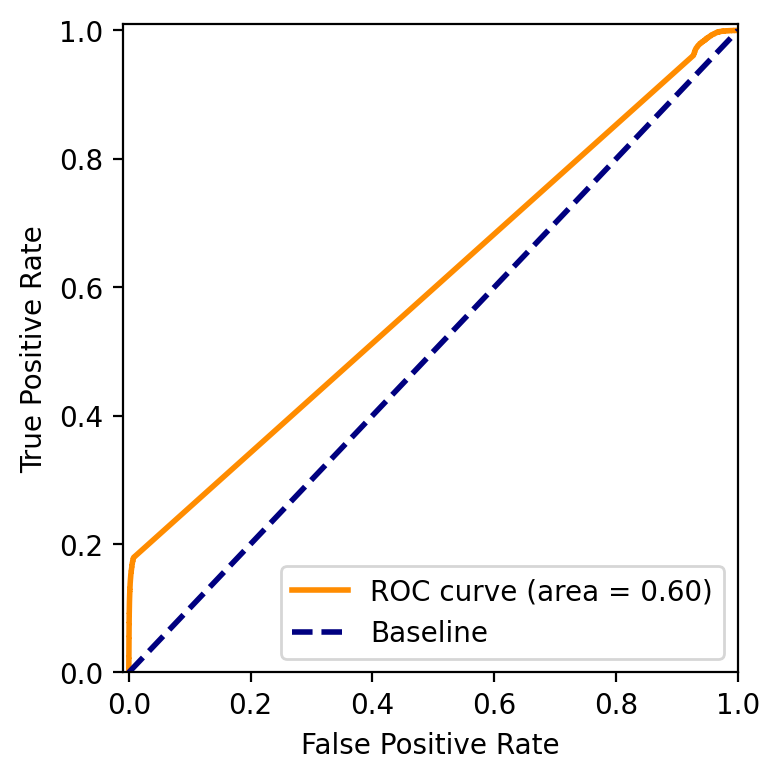

In [14]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(dpi=200, figsize=(4,4))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,          # AUC: reflects performance from plot with a single score
)
plt.plot([0, 1], [0, 1],                                 # Baseline performance (flipping a coin)
         color="navy", 
         lw=lw, 
         linestyle="--", 
         label='Baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("snguess_hutns_roc.pdf")

We can also plot the precision-recall curve.

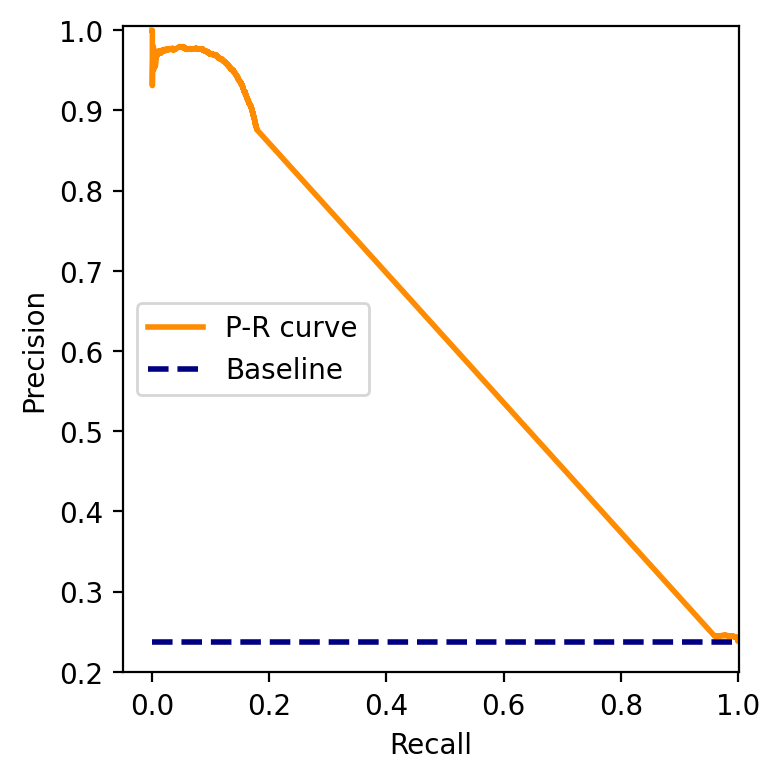

In [15]:
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_true, y_score)
no_skill = np.sum(y_true) / len(y_true)
fig, ax = plt.subplots(dpi=200, figsize=(4,4))
plt.plot(lr_recall, lr_precision, linestyle='-', lw=lw, label='P-R curve', color="darkorange")       
plt.plot(                         # Plot baseline performance
    [0, 1], 
    [no_skill, no_skill], 
    linestyle='--', 
    lw=lw, 
    label='Baseline', 
    color='navy') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(top=1.005)
plt.xlim(right=1.001)
plt.legend(loc='center left')
plt.tight_layout()
plt.savefig("snguess_hutns_prerec.pdf")

If we explicitly set a probability-like threshold of 0.5 for a positive classification, then we can calculate other performance metrics.

In [16]:
y_true = snguess.targeted_by_bts
y_pred = snguess.SNGuessProb > 0.5

In [17]:
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, inverse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.875981
Recall (best=1.0, worse=0.0): 0.178919
F1-score (best=1.0, worse=0.0): 0.297146
MCC (perfect=+1.0, random=0.0, inverse=-1.0): 0.338784


We can also take a look to the confusion matrix of the classification.

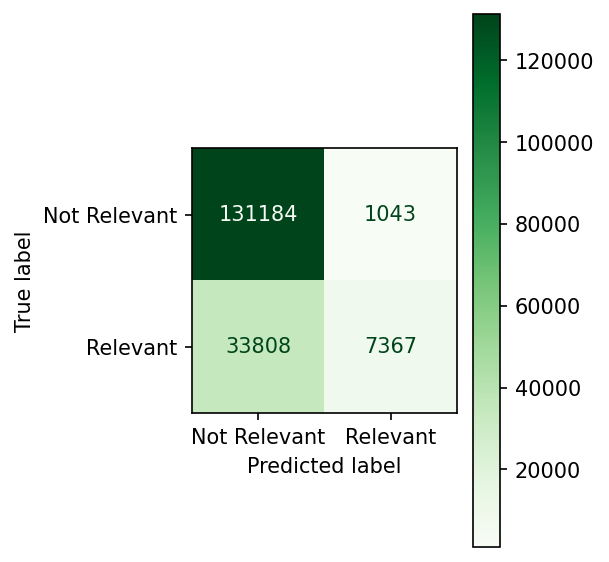

In [18]:
plot_confusion_matrix(y_true, y_pred, ['Not Relevant', 'Relevant'])
plt.tight_layout()
plt.savefig("snguess_hutns_conf.pdf")

## Only Those Evaluated by the Classification Model

We can also apply the previous analysis, but instead of considering the whole `snguess_hu_tns_msip` ZTF alert dataset, we consider only those alerts that were in fact analyzed and explicitly assigned a score by SNGuess' classification model. 

In [19]:
snguess_classified = snguess[snguess.SNGuessBool.notna()]

The classification terms for this subset are similar to the previous ones:

1. Actual positive: any alert of a candidate targeted by BTS;
1. Actual negative: any alert of a candidate not targeted by BTS;
1. Predicted positive: any alert with an SNGuess score above threshold;
1. Predicted negative: any alert with an SNGuess score below threshold (must have a non-default score).

In [20]:
snguess_classified = snguess[snguess.SNGuessBool.notna()]
y_true = snguess_classified.targeted_by_bts
y_score = snguess_classified.SNGuessProb

Without setting a fixed classification threshold score, we can plot the ROC and calculate the ROC AUC metric.

We will do two plots. A first one with the ROC curve, and then a second one with the ROC curve zoomed in, to highlight the performance for a false positive rate from 0 to 0.1.

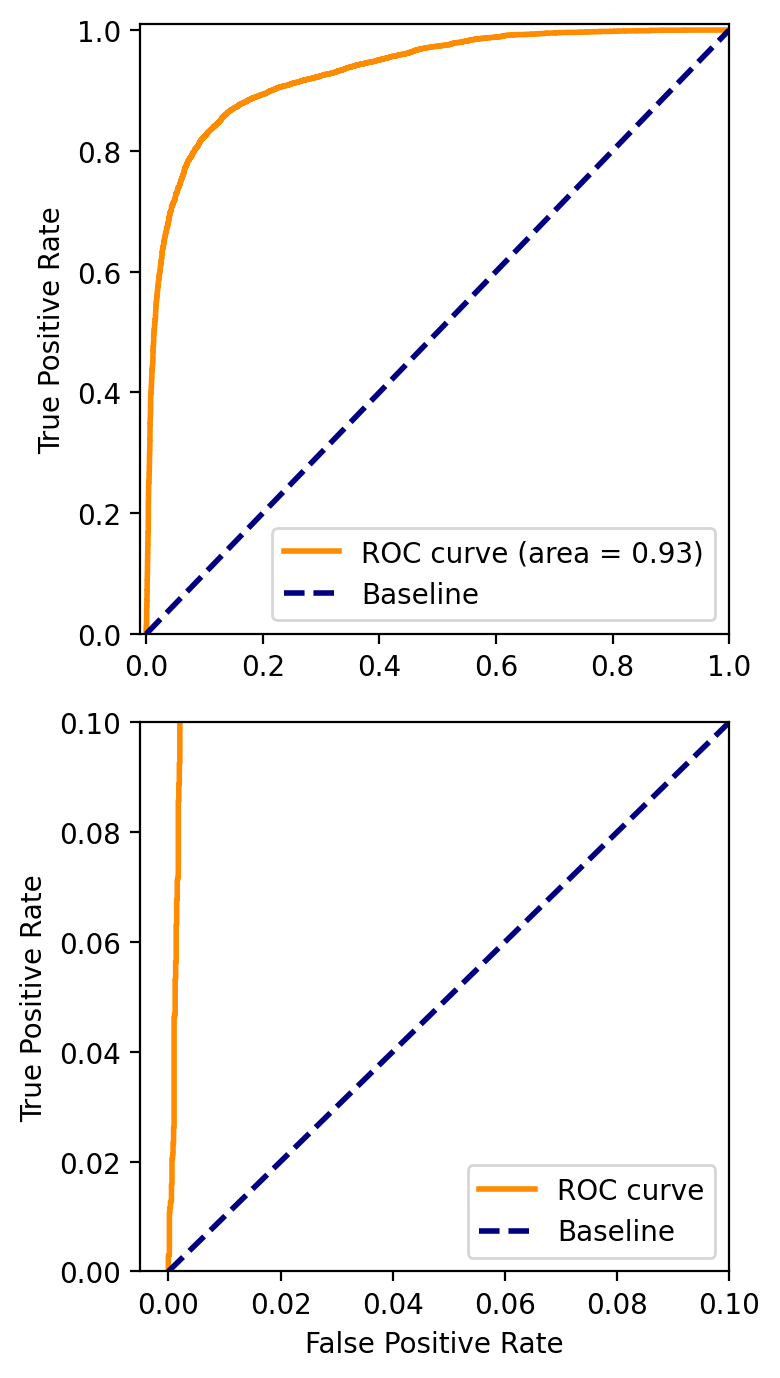

In [21]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, dpi=200, figsize=(4,7), gridspec_kw={'height_ratios': [10, 9]})
lw = 2

# General plot
ax1.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,          # AUC: reflects performance from plot with a single score
)
ax1.plot([0, 1], [0, 1],                                 # Baseline performance (flipping a coin)
         color="navy", 
         lw=lw, 
         linestyle="--", 
         label='Baseline')
ax1.set_xlim([-0.01, 1.0])
ax1.set_ylim([0.0, 1.01])
ax1.set_ylabel("True Positive Rate")
ax1.legend(loc="lower right")

# Zoomed plot
ax2.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve" % roc_auc,
)
ax2.plot([0, 1], [0, 1],
         color="navy", 
         lw=lw, 
         linestyle="--", 
         label='Baseline')
ax2.set_xlim([-0.005, 0.1])
ax2.set_ylim([0.0, 0.1])
ax2.set_ylabel("True Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig("snguess_hutns_class_roc.pdf")

We can also plot the precision-recall curve.

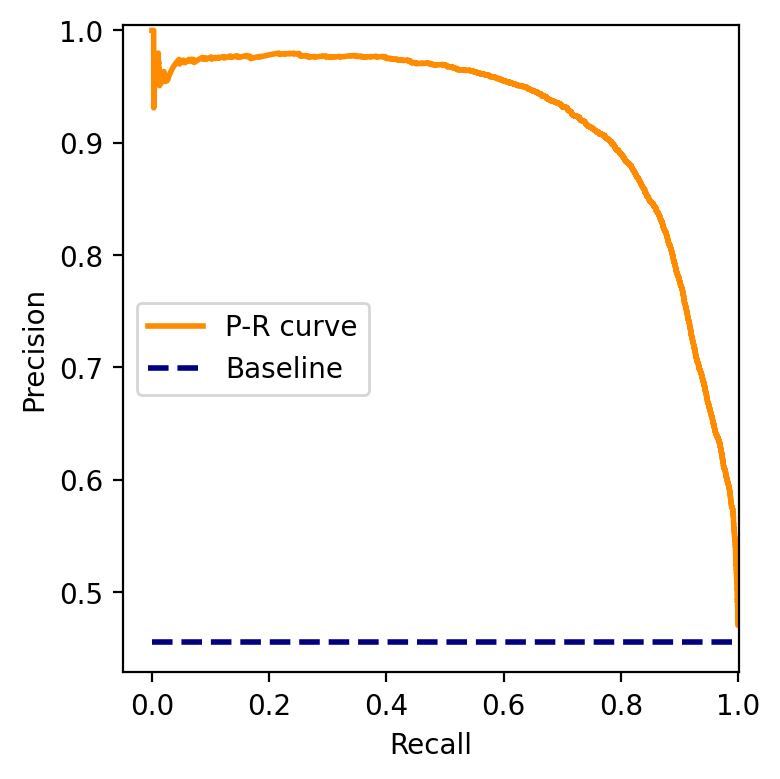

In [22]:
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_true, y_score)
no_skill = np.sum(y_true) / len(y_true)
fig, ax = plt.subplots(dpi=200, figsize=(4,4))
plt.plot(lr_recall, lr_precision, linestyle='-', lw=lw, label='P-R curve', color="darkorange")       
plt.plot(                         # Plot baseline performance
    [0, 1], 
    [no_skill, no_skill], 
    linestyle='--', 
    lw=lw, 
    label='Baseline', 
    color='navy') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(top=1.005)
plt.xlim(right=1.001)
plt.legend(loc='center left')
plt.tight_layout()
plt.savefig("snguess_hutns_class_prerec.pdf")

If we explicitly set a probability-like threshold of 0.5 for a positive classification, then we can calculate other performance metrics.

In [23]:
y_true = snguess_classified.targeted_by_bts
y_pred = snguess_classified.SNGuessProb > 0.5

In [24]:
print("Precision (best=1.0, worse=0.0): %f" % metrics.precision_score(y_true, y_pred))
print("Recall (best=1.0, worse=0.0): %f" % metrics.recall_score(y_true, y_pred))
print("F1-score (best=1.0, worse=0.0): %f" % metrics.f1_score(y_true, y_pred))
print("MCC (perfect=+1.0, random=0.0, worse=-1.0): %f" % metrics.matthews_corrcoef(y_true, y_pred))

Precision (best=1.0, worse=0.0): 0.875981
Recall (best=1.0, worse=0.0): 0.820836
F1-score (best=1.0, worse=0.0): 0.847512
MCC (perfect=+1.0, random=0.0, worse=-1.0): 0.728477


We can also take a look to the confusion matrix of the classification.

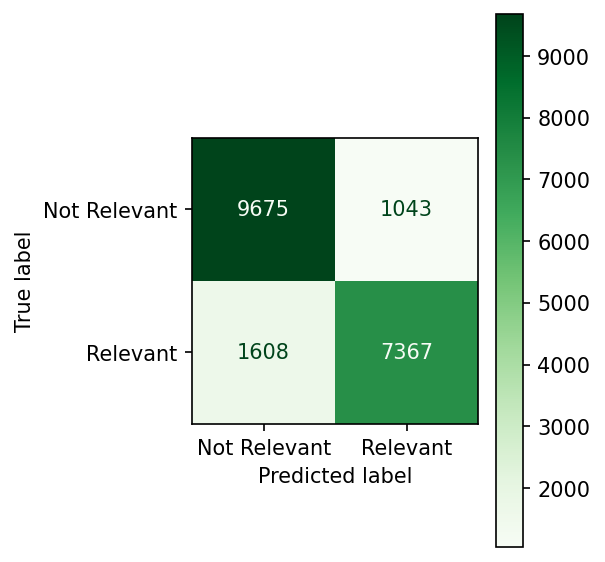

In [25]:
plot_confusion_matrix(y_true, y_pred, ['Not Relevant', 'Relevant'])
plt.tight_layout()
plt.savefig("snguess_hutns_class_conf.pdf")

# Precision Analysis

The main goal of SNGuess is achieving a high precision when recommending candidates for follow up observations. It is interesting to see how is the precision of SNGuess' recommendations across different kinds of alert.

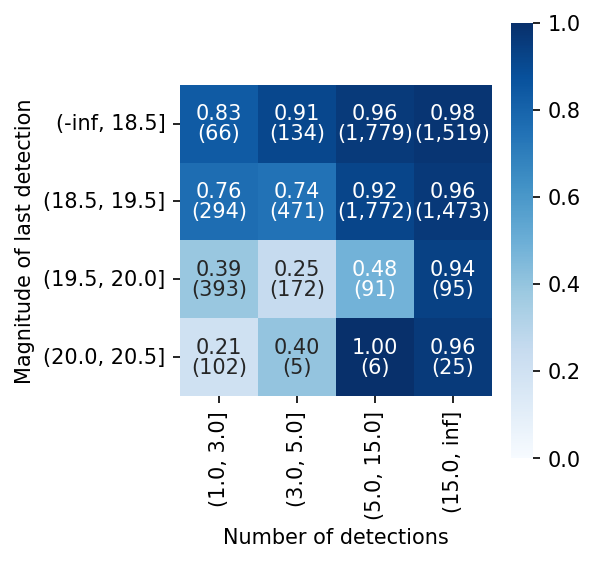

In [26]:
# Cut values in mag_last and ndet for bins
mag_last_cuts = pd.IntervalIndex.from_breaks([-float("inf"),18.5,19.5,20,20.5])
ndet_cuts = pd.IntervalIndex.from_breaks([1, 3, 5, 15, float('inf')])

# Matrix with counts for all selected by SNGuess
snguess_positive = snguess[snguess.SNGuessProb > 0.5]
positive_counts = pd.merge(
    pd.cut(snguess_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrix with counts for all selected by SNGuess and relevant
snguess_true_positive = snguess[(snguess.SNGuessProb > 0.5) & (snguess.targeted_by_bts)]
true_positive_counts = pd.merge(
    pd.cut(snguess_true_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_true_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrices for ratios (float values) and counts (strings  with integer numeric values between parentheses)
precisions = true_positive_counts / positive_counts
count_annotations = positive_counts.stack().map(int).map('({:,d})'.format).unstack()

# Plot binned matrix with precisions and counts
fig, ax = plt.subplots(dpi=150, figsize=(4,4))
sns.heatmap(precisions, cmap='Blues', annot=True, annot_kws={'va':'bottom'}, 
            fmt='.2f', vmin=0.0, vmax=1.0, square=True)
sns.heatmap(precisions, cmap='Blues', annot=count_annotations, annot_kws={'va':'top'}, 
            fmt='', cbar=False, vmin=0.0, vmax=1.0)
plt.xlabel('Number of detections')
plt.ylabel('Magnitude of last detection')
plt.tight_layout()
plt.savefig("snguess_hutns_prec.pdf")

Now, let's analize precision for the subset of transients where `distnr_med` > 1.0

In [27]:
snguess_distnr_1 = snguess[snguess.distnr_med > 1.0]

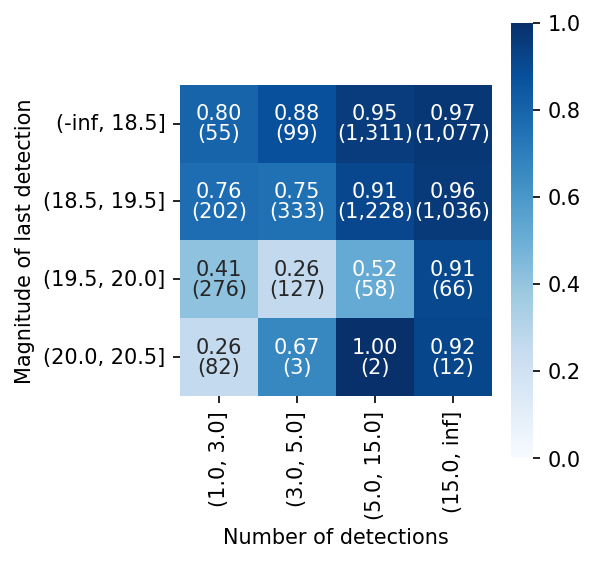

In [28]:
# Cut values in mag_last and ndet for bins
mag_last_cuts = pd.IntervalIndex.from_breaks([-float("inf"),18.5,19.5,20,20.5])
ndet_cuts = pd.IntervalIndex.from_breaks([1, 3, 5, 15, float('inf')])

# Matrix with counts for all selected by SNGuess
snguess_positive = snguess_distnr_1[snguess_distnr_1.SNGuessProb > 0.5]
positive_counts = pd.merge(
    pd.cut(snguess_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrix with counts for all selected by SNGuess and relevant
snguess_true_positive = snguess_distnr_1[(snguess_distnr_1.SNGuessProb > 0.5) & (snguess_distnr_1.targeted_by_bts)]
true_positive_counts = pd.merge(
    pd.cut(snguess_true_positive.mag_last, mag_last_cuts),
    pd.cut(snguess_true_positive.ndet, ndet_cuts, right=False),
    left_index=True,
    right_index=True,
)\
.value_counts()\
.unstack(level=1)

# Matrices for ratios (float values) and counts (strings  with integer numeric values between parentheses)
precisions = true_positive_counts / positive_counts
count_annotations = positive_counts.stack().map(int).map('({:,d})'.format).unstack()

# Plot binned matrix with precisions and counts
fig, ax = plt.subplots(dpi=150, figsize=(4,4))
sns.heatmap(precisions, cmap='Blues', annot=True, annot_kws={'va':'bottom'}, 
            fmt='.2f', vmin=0.0, vmax=1.0, square=True)
sns.heatmap(precisions, cmap='Blues', annot=count_annotations, annot_kws={'va':'top'}, 
            fmt='', cbar=False, vmin=0.0, vmax=1.0)
plt.xlabel('Number of detections')
plt.ylabel('Magnitude of last detection')
plt.tight_layout()
plt.savefig("snguess_hutns_prec_distnr1.pdf")